In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import pandas as pd
# from palettable.colorbrewer.diverging import RdBu_8

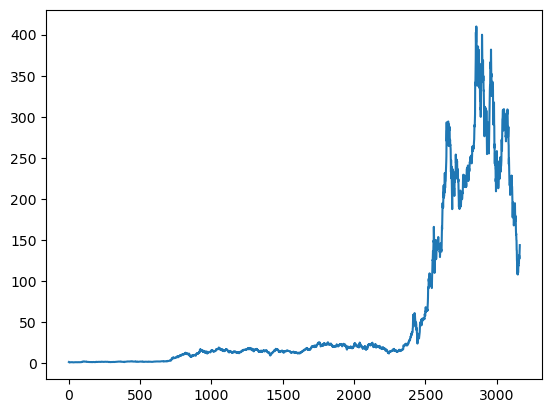

In [4]:
df = pd.read_csv('../TSLA.csv')
plt.plot(df['Adj Close'])
plt.show()

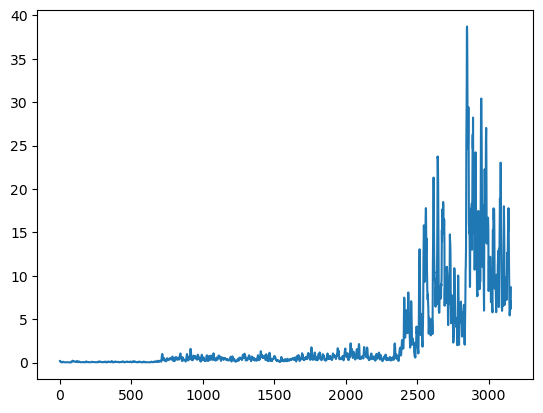

In [16]:
windows = 10
data = df['Adj Close'].rolling(windows).std()[windows-1:].values
plt.plot(data)
plt.show()

Maximum of $\mu$

In [59]:
delta = 1e-2
c_scale = 3
arms = np.arange(len(data))
mu_m_delta = np.quantile(data, 1-delta) * c_scale
mu_m = np.max(data) * c_scale

In [60]:
def mu(x):
    # x in range [0, 1]
    x = int(np.floor(x*len(data)))
    return data[x] * c_scale

In [61]:
def sample(p):
    x = np.random.uniform(cubes[p][0], cubes[p][0] + cubes[p][1])
    return np.random.normal(mu(x), 0.1), mu(x)

In [62]:
def sample_final(time, p_h, p_t):
    global timer
    global regret
    global regret_delta
    pointer = p_h
    for t in range(time):
        r, mu_s = sample(pointer)
        cubes[pointer][2] = cubes[pointer][2] + r
        pointer = pointer + 1
        if pointer > p_t:
            pointer = p_h
        regret = max(mu_m - mu_s, 0)
        regret_delta = max(mu_m_delta - mu_s, 0)
        regretlist.append(regret)
        regret_delta_lst.append(regret_delta)
        timer = timer + 1
    return(regret)

In [63]:
def sample_fullbatch(num, p_h, p_t):
    global timer
    global regret
    global regret_delta
    for t in range(num):
        for cube_now in range(p_h, p_t + 1):
            r, mu_s = sample(cube_now)
            cubes[cube_now][2] = cubes[cube_now][2] + r
            regret = max(mu_m - mu_s, 0)
            regret_delta = max(mu_m_delta - mu_s, 0)
            regretlist.append(regret)
            regret_delta_lst.append(regret_delta)
            timer = timer + 1
    return(regret)

In [64]:
def eli_par(r, mu_max, p_h, p_t, num_p):
#     print('elimination----')
    p_new = p_t
    for p in range(p_h, p_t + 1):
        if mu_max - cubes[p][2] > 1 * r:  #mark2: 0.25
#             print(mu_max, cubes[p][2], r, 'eli')
            cubes_eli.append([[cubes[p][0], cubes[p][0] + cubes[p][1]], [cubes[p][0], cubes[p][0] + cubes[p][1]]])
            continue
#         print(mu_max, cubes[p][2], r)
        for i in range(num_p):
            cubes.append([cubes[p][0] + i * cubes[p][1] / num_p, cubes[p][1] / num_p, 0])
        p_new = p_new + num_p
#         for i in range(num_p - 1):
#             partition.append([cubes[p][0] + cubes[p][2] / num_p * (i + 1), cubes[p][1], cubes[p][0] + cubes[p][2] / num_p * (i + 1), cubes[p][1] + cubes[p][2]])
#         for i in range(num_p - 1):
#             partition.append([cubes[p][0], cubes[p][1] + cubes[p][2] / num_p * (i + 1), cubes[p][0] + cubes[p][2], cubes[p][1] + cubes[p][2] / num_p * (i + 1)])
#     partition_grid.append(len(partition)-1)
#     cubes_eli_grid.append(len(cubes_eli)-1)
    return p_new

In [65]:
regrets_all = []
regrets_delta_all = []


for i in range(10):
    print(i)

    T=20000
    edge_length = []
    num = []  # number of samples in each batch
    # partition = []   # edge of the cubes
    # partition_grid = []
    cubes_eli = []   # cubes that have been eliminated
    cubes_eli_grid = []
    regretlist = []
    regretlist.append(0)

    regret_delta_lst = []
    regret_delta_lst.append(0)

    grid = []
    timer = 0
    eli_cubes_num = [] #number of cubes totally eliminated each batch
    cubes_num = []

    # ACE Sequence

    ACE_c = []
    ACE_d = []
    ACE_c.append( 1 / 3 * math.log2(T / math.log2(T)))      ###mark3: d_{z} = 1?
    c_cumu = ACE_c[-1]
    eta = 3 / 4
    B_star = math.ceil(math.log2(math.log2(T)) / math.log2(3))  
    # print(B_star)
    for i in range(B_star):
        ACE_d.append(math.floor(c_cumu))
        ACE_d.append(math.ceil(c_cumu))
        ACE_c.append(ACE_c[-1] * eta)
        c_cumu = c_cumu + ACE_c[-1]
#     ACE_d = sorted(list(set(ACE_d)))

    for i in ACE_d:
        edge_length.append(pow(2, -i))

#     print(ACE_d)

    for r in edge_length:
        num.append(math.ceil( 0.01 * math.log(T) / (r)**2 )) ###mark1 0.75

    cubes = []

    # x_location  y_location  edge_length  total_reward

    for i in range(round(1 / edge_length[0])):
        cubes.append([i * edge_length[0], edge_length[0], 0])

    # for i in range(round(2 / edge_length[0]) - 1):
    #     partition.append([0, edge_length[0] * (i + 1), 1, edge_length[0] * (i + 1)])
    #     partition.append([edge_length[0] * (i + 1), 0, edge_length[0] * (i + 1), 1])

    # partition_grid.append(-1)
    # partition_grid.append(len(partition)-1)

    # cubes_eli_grid.append(-1)
    # cubes_eli_grid.append(len(cubes_eli)-1)
    grid.append(0)

    pointer_h = 0
    pointer_t = round(1 / edge_length[0]) - 1

    B_total = len(edge_length)



    T_accu = 0   # number of past rounds
    regret = 0
    regret_delta = 0

    for B in range(T):   # number of batches B is less than time horizon T
        if B == B_total:
            r = sample_final(T - T_accu, pointer_h, pointer_t)
            grid.append(T)
            break
        num_cube = pointer_t - pointer_h + 1
        num_round = num_cube * num[B]
        if (T_accu + num_round >= T) or (B == B_total):
            r = sample_final(T - T_accu, pointer_h, pointer_t)
            grid.append(T)
            break
        if T_accu + num_round < T:
            T_accu = T_accu + num_round
            r = sample_fullbatch(num[B], pointer_h, pointer_t)
            grid.append(T_accu)
            # compute the average reward for each cube and the maximal
            hat_mu_max = 0
            for p in range(pointer_h, pointer_t + 1):
                cubes[p][2] = cubes[p][2] / num[B]
                if cubes[p][2] > hat_mu_max:
                    hat_mu_max = cubes[p][2]
            if B == B_total -1:
                num_p = 2
            else:
                num_p = round(edge_length[B] / edge_length[B + 1])
            cubes_num.append(len(cubes))
            p_t = eli_par(edge_length[B], hat_mu_max, pointer_h, pointer_t, num_p)

            eli_cubes_num.append(len(cubes_eli))

            pointer_h = pointer_t + 1
            pointer_t = p_t
            
            
    print('cubes_num', cubes_num)
    print('eli_cubes_num', eli_cubes_num)
        
    regrets_all.append(regretlist)
    regrets_delta_all.append(regret_delta_lst)

0
cubes_num [8, 10, 14, 16, 18]
eli_cubes_num [7, 8, 11, 12, 13]
1
cubes_num [8, 10, 14, 16, 18]
eli_cubes_num [7, 8, 11, 12, 13]
2
cubes_num [8, 10, 14, 16, 18]
eli_cubes_num [7, 8, 11, 12, 13]
3
cubes_num [8, 10, 14, 16, 18]
eli_cubes_num [7, 8, 11, 12, 13]
4
cubes_num [8, 10, 14, 16, 18]
eli_cubes_num [7, 8, 11, 12, 13]
5
cubes_num [8, 10, 14, 16, 18]
eli_cubes_num [7, 8, 11, 12, 13]
6
cubes_num [8, 10, 14, 16, 18]
eli_cubes_num [7, 8, 11, 12, 13]
7
cubes_num [8, 10, 14, 16, 18]
eli_cubes_num [7, 8, 11, 12, 13]
8
cubes_num [8, 10, 14, 16, 18]
eli_cubes_num [7, 8, 11, 12, 13]
9
cubes_num [8, 10, 14, 16, 18]
eli_cubes_num [7, 8, 11, 12, 13]


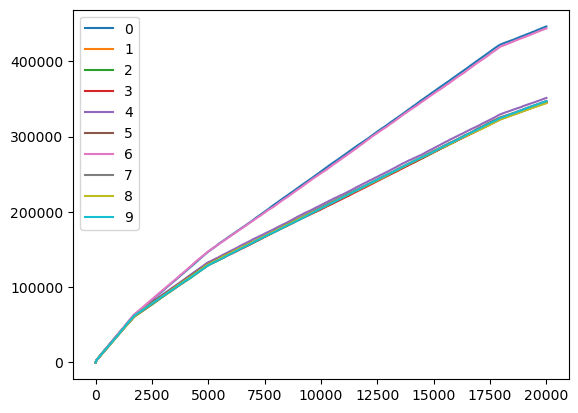

In [66]:
# for i in range(10):
#     plt.plot(np.cumsum(regrets_all, axis=1)[i], label='{}'.format(i))
# plt.legend()
# plt.show()

for i in range(10):
    plt.plot(np.cumsum(regrets_delta_all, axis=1)[i], label='{}'.format(i))
plt.legend()
plt.show()

In [67]:
grid

[0, 56, 108, 1732, 4978, 17960, 20000]

In [68]:
import numpy as np
# regret_m = np.mean(np.cumsum(regrets_all, axis=1), axis=0)
# regret_std = np.std(np.cumsum(regrets_all, axis=1), axis=0) 
regret_m_delta = np.mean(np.cumsum(regrets_delta_all, axis=1), axis=0)
regret_std_delta = np.std(np.cumsum(regrets_delta_all, axis=1), axis=0)

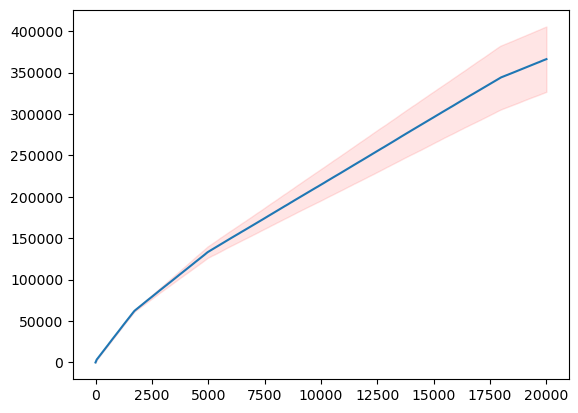

In [69]:
import matplotlib.pyplot as plt
# plt.plot(regret_m)
plt.plot(regret_m_delta)
# plt.fill_between(np.array(range(len(regret_m))), 
#                  regret_m - regret_std, regret_m + regret_std, alpha=0.1, color='b')
plt.fill_between(np.array(range(len(regret_m_delta))), 
                                regret_m_delta - regret_std_delta, regret_m_delta + regret_std_delta, alpha=0.1, color='r')
plt.show()

In [16]:
import numpy as np
np.savetxt('ABLiN_delta.csv', regrets_delta_all)
# np.savetxt('ABLiN.csv', regrets_all)